In [1]:
import sys
sys.path.append('..')
import condense
import numpy as np
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
from condense.keras import PruningWrapper, PruningCallback
from condense.optimizer.sparsity_functions import Constant
from keras.layers import Dense
import matplotlib.pyplot as plt
from copy import deepcopy
tf.get_logger().setLevel(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Construct a tf.data.Dataset
ds, ds_test = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)
ds = ds.repeat()

def generator(batch_size, data_set):
    while True:
        X, y = next(tfds.as_numpy(data_set.batch(batch_size)))
        yield X.reshape(batch_size, 784), keras.utils.to_categorical(y, 10)
        

gen = generator(100, ds)
gen_valid = generator(10, ds_test) 

SPARSITY_TARGET = 0.9
LAYER_UNITS = [1000, 250]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)
INPUT_SHAPE = next(gen)[0].shape
TRAINING_EPOCHS = 20
ACTIVATION_FUNCTION = 'relu'

_ = next(gen)

# Test Model

In [2]:
model = keras.models.Sequential(layers=[
    PruningWrapper(Dense(LAYER_UNITS[0], input_shape=INPUT_SHAPE, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(100, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(50, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    Dense(10, activation='softmax')
])
model.compile(OPTIMIZER, 'categorical_crossentropy')
model.build(input_shape=INPUT_SHAPE)

model.save('models/dense_mnist_lottery.h5')

INITIAL_PARAMETERS = deepcopy(model.get_weights())

# Finding Winning Ticket

In [3]:
hist_winning_ticket = model.fit(gen, epochs=10, steps_per_epoch=20, validation_data=gen_valid, validation_steps=3, callbacks=[PruningCallback()], verbose=0)

## Winning Ticket Found

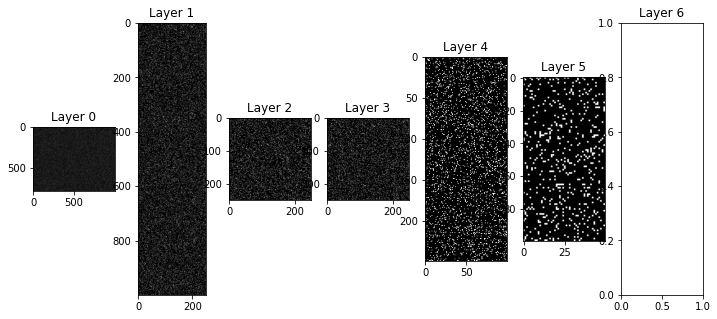

In [4]:
ticket_weights = []
for layer in model.layers:
    if isinstance(layer, PruningWrapper):
        ticket_weights.append(deepcopy(layer.mask.numpy()))
    else:
        ticket_weights.append(None)
        
plt.figure(figsize=(12, 5))
plt.title('Winning Ticket Mask')
for i, layer in enumerate(model.layers):
    plt.subplot(1,len(model.layers), i+1)
    plt.title(f'Layer {i} Mask')
    if isinstance(layer, PruningWrapper):
        plt.imshow(layer.mask.numpy(), vmin=0, vmax=1, cmap='gist_gray')

# Actual training on winning ticket
## Resetting parameter configuration to initial values

In [5]:
training_model = keras.models.Sequential(layers=[
    PruningWrapper(Dense(LAYER_UNITS[0], input_shape=INPUT_SHAPE, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(100, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(50, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    Dense(10, activation='softmax')
])
# training_model = keras.models.load_model('models/dense_mnist_lottery.h5')
training_model.compile(OPTIMIZER, 'categorical_crossentropy')
training_model.build(input_shape=INPUT_SHAPE)
training_model.set_weights(INITIAL_PARAMETERS)

# Assign winning ticket mask to model
for ticket_weight, layer in zip(ticket_weights, training_model.layers[:-1]):
    layer.mask.assign(ticket_weight)

In [6]:
hist_training = training_model.fit(gen, epochs=TRAINING_EPOCHS, steps_per_epoch=20, validation_data=gen_valid, validation_steps=3, verbose=0)

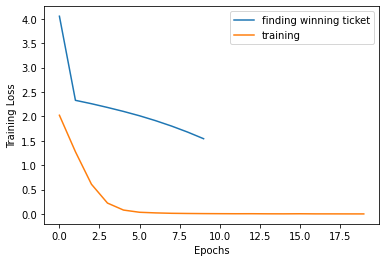

In [7]:
plt.plot(hist_winning_ticket.history['loss'], label='finding winning ticket')
plt.plot(hist_training.history['loss'], label='training')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

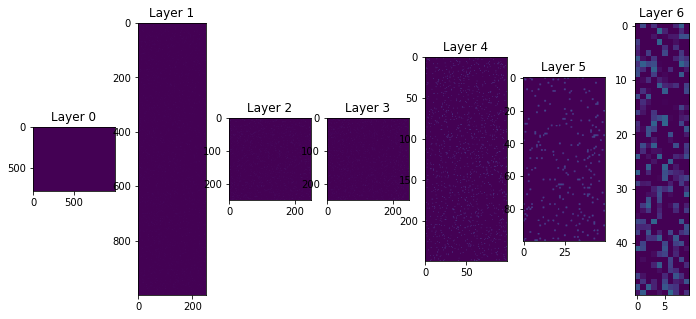

In [8]:
plt.figure(figsize=(12, 5))
for i, layer in enumerate(training_model.layers):
    plt.subplot(1,len(training_model.layers), i+1)
    plt.title(f'Layer {i}')
    if isinstance(layer, PruningWrapper):
        plt.imshow(layer.layer.kernel.numpy(), vmin=0, vmax=1)
    else:
        plt.imshow(layer.kernel.numpy(), vmin=0, vmax=1)

# Classical training without masking

In [ ]:
classical_model = keras.models.Sequential(layers=[
    PruningWrapper(Dense(LAYER_UNITS[0], input_shape=INPUT_SHAPE, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(LAYER_UNITS[1], activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(100, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    PruningWrapper(Dense(50, activation=ACTIVATION_FUNCTION), Constant(SPARSITY_TARGET)),
    Dense(10, activation='softmax')
])

classical_model.compile(OPTIMIZER, 'categorical_crossentropy')
classical_model.build(input_shape=INPUT_SHAPE)
classical_model.set_weights(INITIAL_PARAMETERS)

hist_classical = classical_model.fit(gen, epochs=TRAINING_EPOCHS, steps_per_epoch=20, verbose=0, validation_data=gen_valid, validation_steps=3)

(0.0, 20.0, 0.0, 20.0)

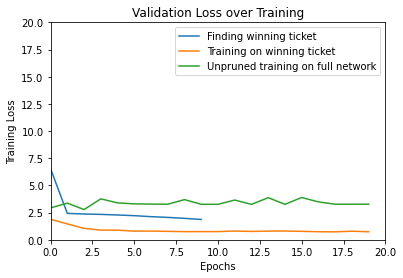

In [10]:
plt.title('Validation Loss over Training')
plt.plot(hist_winning_ticket.history['val_loss'], label='Finding winning ticket')
plt.plot(hist_training.history['val_loss'], label='Training on winning ticket')
plt.plot(hist_classical.history['val_loss'], label='Unpruned training on full network')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.axis([0, TRAINING_EPOCHS, 0, 20])

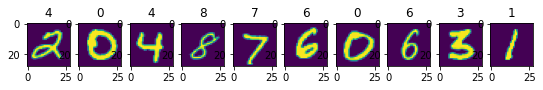

In [11]:
X, y = next(gen_valid)
guess = training_model.predict(X)
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,11,i+1)
    plt.title(np.argmax(guess[i]))
    plt.imshow(X[i].reshape(28,28,1))

# Comparison on single layer

In [27]:
for layer in training_model.layers[:-1]:
    sparsity = condense.utils.layer_utils.calc_layer_sparsity(layer.layer.kernel.numpy())
    sparsity_mask = condense.utils.layer_utils.calc_layer_sparsity(layer.mask.numpy())
    assert abs(sparsity - sparsity_mask) < 1e-9

Text(0.5, 1.0, 'Kernel on unpruned network')

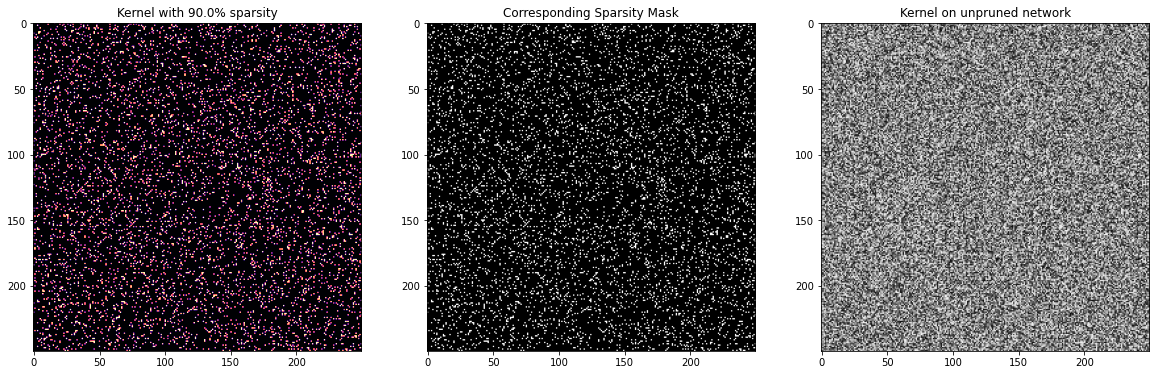

In [26]:
LAYER = 2
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.imshow(np.abs(training_model.layers[LAYER].layer.kernel.numpy()), cmap='magma', vmin=0, vmax=.1)
sparsity = condense.utils.layer_utils.calc_layer_sparsity(training_model.layers[LAYER].layer.kernel.numpy())
plt.title(f'Kernel with {sparsity*100}% sparsity')

plt.subplot(1, 3, 2)
plt.imshow(training_model.layers[LAYER].mask.numpy() == 0, cmap='binary')
plt.title('Corresponding Sparsity Mask')

plt.subplot(1, 3, 3)
plt.imshow(classical_model.layers[LAYER].layer.kernel.numpy(), cmap='binary')
plt.title('Kernel on unpruned network')